This code propagates a satellite in terms of slight variations in its initial orbital parameters, and stops the propagation when the satellite reaches 80km of altitude. The code then translates the initial Gaussian standard deviation into new uncertainties using the uscented transform mathematical formula. 

This part of the code initializes all the import that will be needed.

In [65]:
# The Gaussian class and unscented_transform used in this code are from:
# https://github.com/hugohadfield/unscented_transform

#setup all the imports needed for the code
import orekit
vm = orekit.initVM()
from math import radians
from orekit.pyhelpers import setup_orekit_curdir
setup_orekit_curdir()
from org.orekit.orbits import OrbitType, KeplerianOrbit, PositionAngleType
from org.orekit.time import AbsoluteDate, TimeScalesFactory
from org.orekit.utils import Constants, IERSConventions
from org.orekit.frames import FramesFactory
from org.orekit.propagation.numerical import NumericalPropagator
from org.hipparchus.ode.nonstiff import DormandPrince853Integrator
from org.orekit.propagation import SpacecraftState
from org.orekit.propagation.events import AltitudeDetector
from org.orekit.propagation.events.handlers import StopOnEvent
from org.orekit.models.earth.atmosphere import NRLMSISE00
from org.orekit.forces.drag import DragForce, IsotropicDrag
from org.orekit.bodies import OneAxisEllipsoid, CelestialBodyFactory
from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel
from org.orekit.models.earth.atmosphere.data import MarshallSolarActivityFutureEstimation
from orekit import JArray_double
from mpl_toolkits.mplot3d import Axes3D


import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from unscented_transform import Gaussian, unscented_transform, plot_ellipse
from scipy.optimize import curve_fit
from scipy import interpolate
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns

This part of the code will set up certain parameters and objects that will be needed later on.

In [101]:
#set the initial date
utc = TimeScalesFactory.getUTC() 
epochDate = AbsoluteDate(2020, 1, 1, 0, 0, 00.000, utc)
initialDate = epochDate
print(Constants.WGS84_EARTH_ANGULAR_VELOCITY)
#set our orbit/satellite parameters
rp = 150000.0
ra = 300000.0
i = radians(98.2)
omega = radians(0)
raan = radians(-212)
lv = radians(0)
satellite_mass = 90.0
playerOne = [90, 1.1, 2.25]
Airbus = [500, [2.78,7.41], 2.25]

a = (rp + ra + 2 * Constants.WGS84_EARTH_EQUATORIAL_RADIUS) / 2.0    
e = 1.0 - (rp + Constants.WGS84_EARTH_EQUATORIAL_RADIUS) / a

#set up the inertial frame where the satellite is defined
inertialFrame = FramesFactory.getEME2000()

#set up the orbit construction as Keplerian
initialOrbit_0 = KeplerianOrbit(a, e, i, omega, raan, lv,
                              PositionAngleType.TRUE,
                              inertialFrame, epochDate, Constants.WGS84_EARTH_MU)

#set up the Earth for the plotting of the orbit later on
ITRF = FramesFactory.getITRF(IERSConventions.IERS_2010, True)
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, 
                         Constants.WGS84_EARTH_FLATTENING, 
                         ITRF)
sun = CelestialBodyFactory.getSun()
msafe = MarshallSolarActivityFutureEstimation(MarshallSolarActivityFutureEstimation.DEFAULT_SUPPORTED_NAMES,
                                              MarshallSolarActivityFutureEstimation.StrengthLevel.AVERAGE)

7.292115e-05


Defines the function that transforms the initial Gaussian variation in the perigee and apogee radii into a Gaussian variation in the semi-major axis and the eccentricity.

In [102]:
def sigma_points(mean, covariance):
    def non_linear_function(x):
        a = (x[0] + x[1]) / 2.0
        e = 1.0 - (x[1]) / a
        return np.array([a, e])
    
    gaussian = Gaussian(mean, covariance)
    
    transformed_gaussian = unscented_transform(gaussian, non_linear_function)
    
    sigma_points = gaussian.compute_sigma_points()
    transformed_sigma_points = [non_linear_function(sp) for sp in sigma_points]
    return transformed_sigma_points, transformed_gaussian

Defines the main function of the code that will propagate the initial orbital parameters of the satellite until it reaches an altitude of 80km above Earth.

In [103]:
def numerical_propagation(x):
    initialOrbit = KeplerianOrbit(float(x[0]),
                                    float(x[1]),
                                i, omega, raan, lv, PositionAngleType.TRUE,
                              inertialFrame, initialDate.shiftedBy(float(x[2])), Constants.WGS84_EARTH_MU)
    #set up the code for the numerical propagation ( use of integrator, tolerances)
    minStep = 0.0001
    maxstep = 1000.0
    initStep = 10.0

    positionTolerance = 1.0

    tolerances = NumericalPropagator.tolerances(positionTolerance, 
                                                initialOrbit, 
                                                initialOrbit.getType())

    integrator = DormandPrince853Integrator(minStep, maxstep, 
        JArray_double.cast_(tolerances[0]),
        JArray_double.cast_(tolerances[1]))
    integrator.setInitialStepSize(initStep)

    #set up the propagator
    initialState = SpacecraftState(initialOrbit, satellite_mass) 
    propagator_num = NumericalPropagator(integrator)
    propagator_num.setOrbitType(OrbitType.CARTESIAN)
    propagator_num.setInitialState(initialState)
    altitude_detector = AltitudeDetector(80000.0, earth).withHandler(StopOnEvent())
    propagator_num.addEventDetector(altitude_detector)
    atmosphere = NRLMSISE00(msafe, sun, earth)
    drag_model = IsotropicDrag(playerOne[1], playerOne[2])
    drag_force = DragForce(atmosphere, drag_model)
    propagator_num.addForceModel(drag_force)

    gravityProvider = GravityFieldFactory.getNormalizedProvider(10, 10)
    propagator_num.addForceModel(HolmesFeatherstoneAttractionModel(FramesFactory.getITRF(IERSConventions.IERS_2010, True), gravityProvider))
    finalDate = initialDate.shiftedBy(float(duration))
    final_state = propagator_num.propagate(initialDate, finalDate)
    pv = final_state.getPVCoordinates()
    OrbitType.CARTESIAN.convertType(propagator_num.getInitialState().getOrbit())
    orbit = final_state.getOrbit()
    keplerian_orbit = KeplerianOrbit(orbit)

    return pv, final_state, keplerian_orbit

This part of the code defines the size of the initial variations, the number of samples that will be taken, and plots the semi-major axis and eccentricity Gaussian variation.

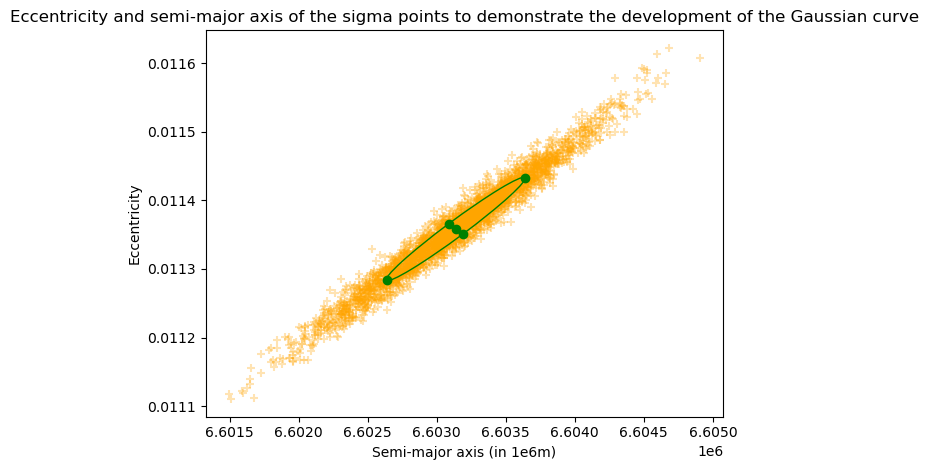

In [104]:
duration = 2*24*3600
sigma_rp = 100.0
sigma_ra = 1000.0
sigma_t = np.radians(0.5)/Constants.WGS84_EARTH_ANGULAR_VELOCITY
mean = np.array([ra+Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                  rp+Constants.WGS84_EARTH_EQUATORIAL_RADIUS])
covariance = np.array([[sigma_ra**2, 0.0], [0.0, sigma_rp**2]])
sig_ae, gaussian_ae = sigma_points(mean, covariance)

new_mean = np.zeros((3))
new_mean[:2] = gaussian_ae.mean()
new_mean[2] = 0.0
new_covariance = np.zeros((3,3))
new_covariance[:2, :2] = gaussian_ae.covariance()
new_covariance[2, 2] = sigma_t**2

newgaussian = Gaussian(new_mean, new_covariance)
sig_points = newgaussian.compute_sigma_points()
weights = newgaussian.compute_weights()
num_samples = 3000
samples = [newgaussian.sample() for _ in range(num_samples)]
samples[:0] = sig_points

ae_ellipse_samples = [gaussian_ae.sample() for _ in range(num_samples)]
x_ae = [item[0] for item in ae_ellipse_samples]
y_ae = [item[1] for item in ae_ellipse_samples]
plt.figure()
ax = plt.gca()
plt.scatter(x_ae, y_ae, alpha = 0.3, color = 'orange', marker = '+')
plot_ellipse(gaussian_ae.mean(), gaussian_ae.covariance(), ax, n_std=1, facecolor='none', edgecolor='green')  
plt.scatter([x[0] for x in sig_ae], [x[1] for x in sig_ae], color='green')
plt.title("Eccentricity and semi-major axis of the sigma points to demonstrate the development of the Gaussian curve")
plt.xlabel("Semi-major axis (in 1e6m)")
plt.ylabel("Eccentricity")
plt.tight_layout()
plt.show()


Creates lists that will append the data obtained from the propagation. Propagation is done for each different sample, and the final data is recorded to be able to plot the variables and analyze them.

In [105]:
lat = []
lon = []
pa = []
time = []
positions = []
velocities = []
inc = []
ohm = []

for j in range(len(samples[:7])):
    pvs, final_state, final_state_orbit = numerical_propagation(samples[j])
    if j == 1:
        og_final_state = final_state_orbit
    v = pvs.getVelocity()
    p = pvs.getPosition()
    x = p.getX()
    y = p.getY()
    z = p.getZ()
    vx = v.getX()
    vy = v.getY()
    vz = v.getZ()
    position = [x, y, z]
    velocity = [vx, vy, vz]
    positions.append(position)
    velocities.append(velocity)
    t = initialDate.shiftedBy(float(final_state.getDate().durationFrom(initialDate)))
    RAAN = final_state_orbit.getRightAscensionOfAscendingNode()
    perig = final_state_orbit.getPerigeeArgument()
    incli = final_state_orbit.getI()
    trueano = final_state_orbit.getTrueAnomaly()
    pa.append(np.degrees(perig+trueano))
    time.append(final_state.getDate().durationFrom(initialDate)/3600)
    inc.append(np.degrees(incli))
    ohm.append(np.degrees(RAAN))
    print(final_state_orbit)
    subpoint = earth.transform(p, inertialFrame, t)
    lat.append(np.degrees(subpoint.getLatitude()))
    lon.append(np.degrees(subpoint.getLongitude()))

Keplerian parameters: {a: 5446336.843474056; e: 0.18713449893494158; i: 97.8253433058011; pa: 189.51374656258238; raan: 149.4265467977404; v: -173.71180082650875;}
Keplerian parameters: {a: 5665371.369067936; e: 0.13808438100940382; i: 98.15804251363143; pa: 286.1395993505049; raan: 149.58640585078294; v: -173.16198852324203;}
Keplerian parameters: {a: 5255795.047221432; e: 0.22642545763695948; i: 98.13249635731185; pa: 108.82843242308904; raan: 149.61996395758635; v: -175.6395920059605;}
Keplerian parameters: {a: 5366584.279021458; e: 0.20465312073797257; i: 97.79234400194807; pa: 166.58406066802488; raan: 149.57828440973793; v: -174.67781313123282;}
Keplerian parameters: {a: 5507711.645650801; e: 0.17265584223849875; i: 97.9774353195924; pa: 217.28062968220564; raan: 149.33462170275203; v: -172.72534932330922;}
Keplerian parameters: {a: 5446917.200191004; e: 0.18700385742516007; i: 97.82596579472093; pa: 189.69290934370252; raan: 149.42552267422204; v: -173.7043853313857;}
Keplerian 

This defines 2 functions that will be used later, which is the Gaussian formula and a function that will unwrap the alpha angles obtained to see a linear dependance with time.

In [106]:
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

def unwrap_angles(perigee):
    unwrapped = [perigee[0]]

    for i in range(1, len(perigee)):
        delta = perigee[i] - perigee[i-1]

        if delta < -180:
            unwrapped.append(unwrapped[-1] + (perigee[i] + 360 - perigee[i-1]))
        elif delta > 180:
            unwrapped.append(unwrapped[-1] + (perigee[i] - 360 - perigee[i-1]))
        else:
            unwrapped.append(unwrapped[-1] + delta)

    return unwrapped

def plot_ellipse(mean: np.ndarray, cov: np.ndarray, ax, n_std=1, num_points=100, **kwargs):

    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)

    theta = np.linspace(0, 2 * np.pi, num_points)
    ellipse_points = np.column_stack([
        ell_radius_x * np.cos(theta),
        ell_radius_y * np.sin(theta)
    ])

    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean[0], mean[1])
    
    transformed_points = transf.transform(ellipse_points)

    ellipse_patch = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, **kwargs)
    ellipse_patch.set_transform(transf + ax.transData)
    ax.add_patch(ellipse_patch)

    return transformed_points

This plots the inclination and the right ascencion of the ascending node in terms of alpha. It shows a clear dependance, that we will be able to fit later on.

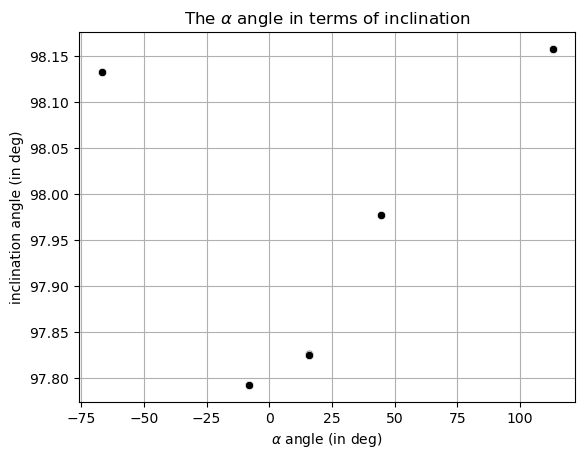

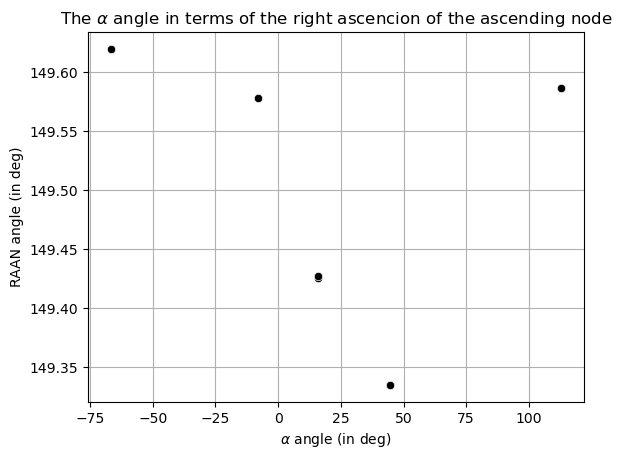

In [107]:
df = pd.DataFrame({
    '$\\alpha$ angle (in deg)': pa,
    'inclination angle (in deg)': inc
})

sns.scatterplot(data=df, x='$\\alpha$ angle (in deg)', y='inclination angle (in deg)', color='black')
plt.title('The $\\alpha$ angle in terms of inclination')
plt.grid(True)
plt.show()

df = pd.DataFrame({
    '$\\alpha$ angle (in deg)': pa,
    'RAAN angle (in deg)': ohm
})

sns.scatterplot(data=df, x='$\\alpha$ angle (in deg)', y='RAAN angle (in deg)', color='black')
plt.title('The $\\alpha$ angle in terms of the right ascencion of the ascending node')
plt.grid(True)
plt.show()

This part of the code will fit the inclination and RAAN data expressed in terms of the $\alpha$ angle. The fit is made using only the points calculated to determine the covariance of the resulting data using the unscented transform

Fitted inclination parameters (i0, i1, i2): [ 9.80151320e+01 -3.74708733e-02 -1.85220220e-01]
[28.017599874357636, 28.417742947056098, 27.672717676529956, 27.918175868273632, 28.136137152222787, 28.075934329190464, 27.959820351636356]
Fitted RAAN parameters (Ω₀, Ω̇, Ω₁, Ω₂): [ 1.51610673e+02 -7.52004249e-02  7.10546806e-03 -1.54647913e-01]


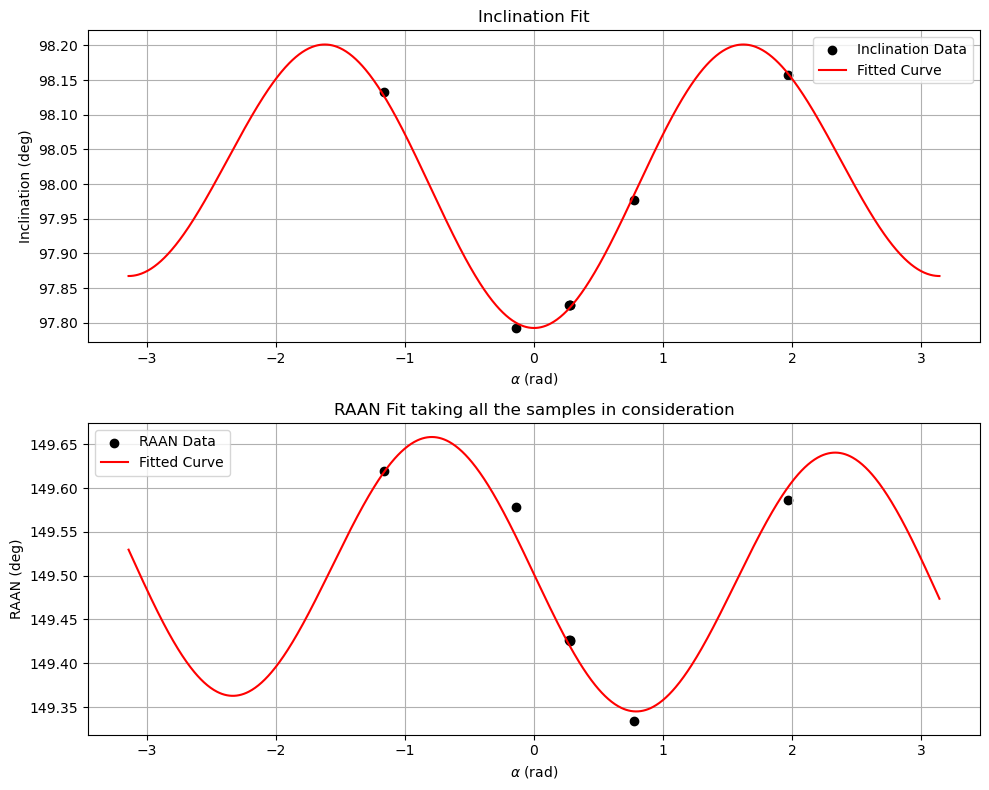

In [108]:
alpha_rad = np.radians(pa)

def inclination_fit(alpha, i0, i1, i2):
    return i0 + i1 * np.cos(alpha) + i2 * np.cos(2 * alpha)

def raan_fit(data, omega0, omega_dot, omega1, omega2):
    alpha, t = data
    return omega0 + omega_dot * t + omega1 * np.sin(alpha) + omega2 * np.sin(2 * alpha)


popt_i, _ = curve_fit(inclination_fit, alpha_rad, inc)
print("Fitted inclination parameters (i0, i1, i2):", popt_i)
print(time)
xdata = np.vstack((alpha_rad, time))
popt_omega, _ = curve_fit(raan_fit, xdata, ohm)
print("Fitted RAAN parameters (Ω₀, Ω̇, Ω₁, Ω₂):", popt_omega)


alpha_fit = np.linspace(-np.pi, np.pi, 1000)
t_fit = np.linspace(min(time), max(time), 1000)

i_fit = inclination_fit(alpha_fit, *popt_i)
omega_fit = raan_fit((alpha_fit, t_fit), *popt_omega)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].scatter(alpha_rad, inc, s = 10, alpha = 0.3)
axs[0].scatter(alpha_rad[:7], inc[:7], label='Inclination Data', color = 'black')
axs[0].plot(alpha_fit, i_fit, 'r', label='Fitted Curve')
axs[0].set_title("Inclination Fit")
axs[0].set_xlabel("$\\alpha$ (rad)")
axs[0].set_ylabel("Inclination (deg)")
axs[0].legend()
axs[0].grid(True)

axs[1].scatter(alpha_rad, ohm, s = 10, alpha = 0.3)
axs[1].scatter(alpha_rad[:7], ohm[:7], label='RAAN Data', color = 'black')
axs[1].plot(alpha_fit, omega_fit, 'r', label='Fitted Curve')
axs[1].set_title("RAAN Fit taking all the samples in consideration")
axs[1].set_xlabel("$\\alpha$ (rad)")
axs[1].set_ylabel("RAAN (deg)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

Fitted inclination parameters (i0, i1, i2): [ 9.80151320e+01 -3.74708733e-02 -1.85220220e-01]
Fitted RAAN parameters (Ω₀, Ω̇, Ω₁, Ω₂): [ 1.51610673e+02 -7.52004249e-02  7.10546806e-03 -1.54647913e-01]


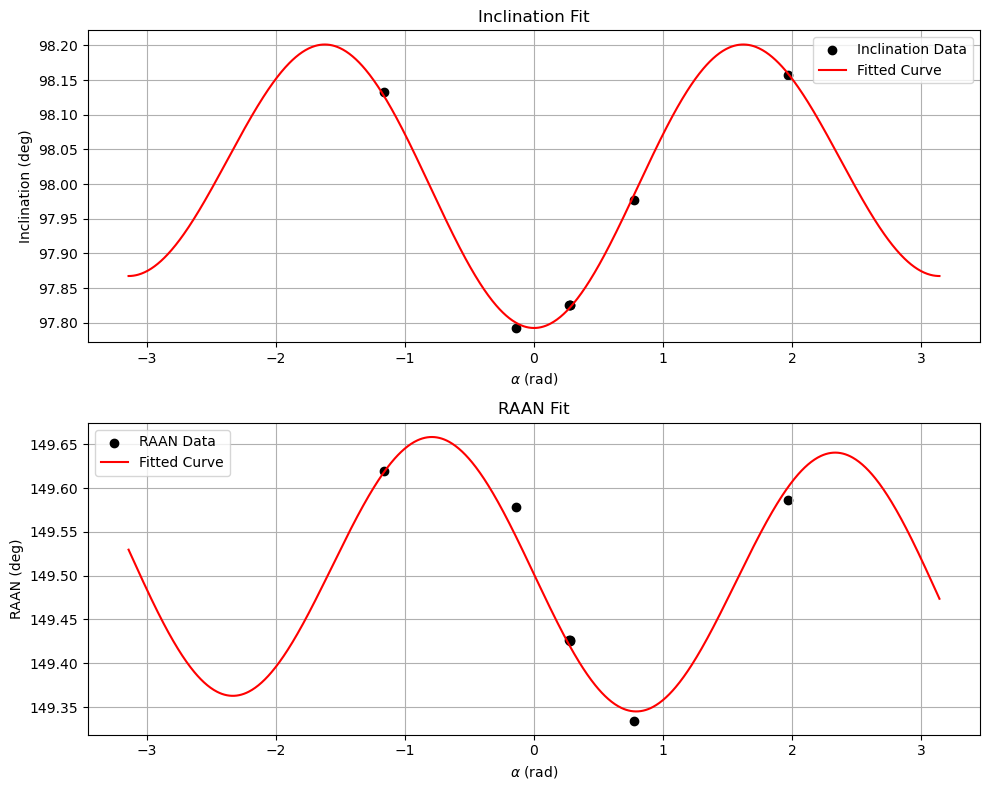

In [109]:
alpha_rad = np.radians(pa)

def inclination_model(alpha, i0, i1, i2):
    return i0 + i1 * np.cos(alpha) + i2 * np.cos(2 * alpha)

def raan_model(data, omega0, omega_dot, omega1, omega2):
    alpha, t = data
    return omega0 + omega_dot * t + omega1 * np.sin(alpha) + omega2 * np.sin(2 * alpha)


popt_i, _ = curve_fit(inclination_model, alpha_rad[:7], inc[:7])
print("Fitted inclination parameters (i0, i1, i2):", popt_i)

xdata = np.vstack((alpha_rad[:7], time[:7]))
popt_omega, _ = curve_fit(raan_model, xdata, ohm[:7])
print("Fitted RAAN parameters (Ω₀, Ω̇, Ω₁, Ω₂):", popt_omega)


alpha_fit = np.linspace(-np.pi, np.pi, 1000)
t_fit = np.linspace(min(time), max(time), 1000)

i_fit = inclination_model(alpha_fit, *popt_i)
omega_fit = raan_model((alpha_fit, t_fit), *popt_omega)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].scatter(alpha_rad, inc, s = 10, alpha = 0.3)
axs[0].scatter(alpha_rad[:7], inc[:7], label='Inclination Data', color = 'black')
axs[0].plot(alpha_fit, i_fit, 'r', label='Fitted Curve')
axs[0].set_title("Inclination Fit")
axs[0].set_xlabel("$\\alpha$ (rad)")
axs[0].set_ylabel("Inclination (deg)")
axs[0].legend()
axs[0].grid(True)

axs[1].scatter(alpha_rad, ohm, s = 10, alpha = 0.3)
axs[1].scatter(alpha_rad[:7], ohm[:7], label='RAAN Data', color = 'black')
axs[1].plot(alpha_fit, omega_fit, 'r', label='Fitted Curve')
axs[1].set_title("RAAN Fit")
axs[1].set_xlabel("$\\alpha$ (rad)")
axs[1].set_ylabel("RAAN (deg)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

This converts the velocities into spherical coordinates to see if there is any strong deviation from the current position as the satellite lands on Earth.

c:\Users\augus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



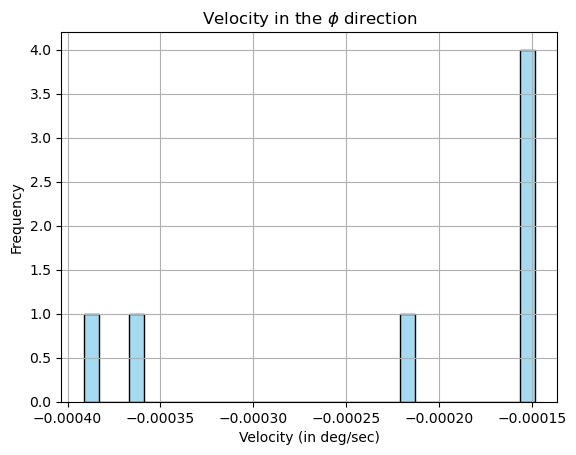

c:\Users\augus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



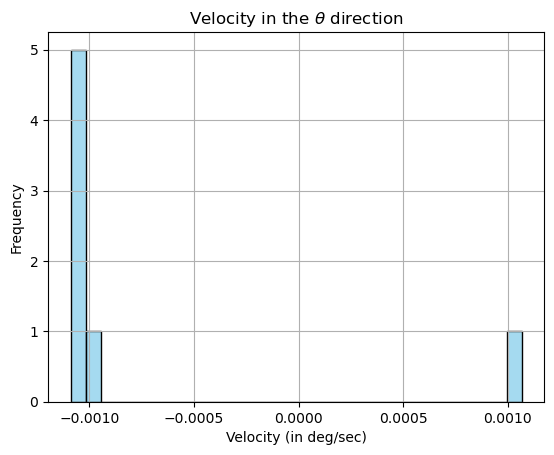

c:\Users\augus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



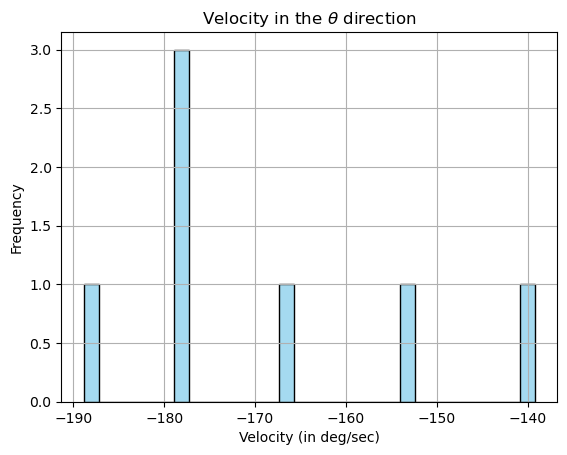

In [110]:
r_vec = []
theta_vec = []
phi_vec = []
for k in range(len(velocities)):
    x, y, z = positions[k]
    r = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arctan2(y, x)
    theta = np.arccos(z / r) 
    vx, vy, vz = velocities[k]
    v_r = vx * np.sin(theta) * np.cos(phi) + vy * np.sin(theta) * np.sin(phi) + vz * np.cos(theta)
    v_theta = vx * np.cos(theta) * np.cos(phi) + vy * np.cos(theta) * np.sin(phi) - vz * np.sin(theta)
    v_phi = -vx * np.sin(phi) + vy * np.cos(phi)
    r_vec.append(v_r)
    theta_vec.append(v_theta/r)
    phi_vec.append(v_phi/r)

sns.histplot(phi_vec, bins=30, kde=False, color='skyblue', edgecolor='black')
plt.xlabel('Velocity (in deg/sec)')
plt.ylabel('Frequency')
plt.title('Velocity in the $\\phi$ direction')
plt.grid(True)
plt.show()

sns.histplot(theta_vec, bins=30, kde=False, color='skyblue', edgecolor='black')
plt.xlabel('Velocity (in deg/sec)')
plt.ylabel('Frequency')
plt.title('Velocity in the $\\theta$ direction')
plt.grid(True)
plt.show()

sns.histplot(r_vec, bins=30, kde=False, color='skyblue', edgecolor='black')
plt.xlabel('Velocity (in deg/sec)')
plt.ylabel('Frequency')
plt.title('Velocity in the $\\theta$ direction')
plt.grid(True)
plt.show()

This part of the code will utilize the unwrapping angles function to unwrap the alpha angles obtained, and will then plot the original alpha in terms of time and the unwrapped alpha in terms of time.

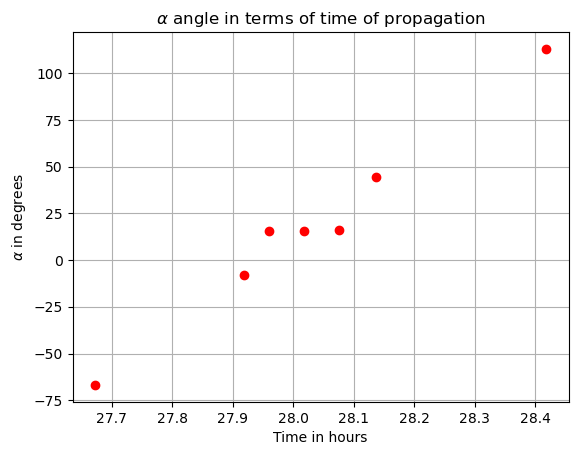

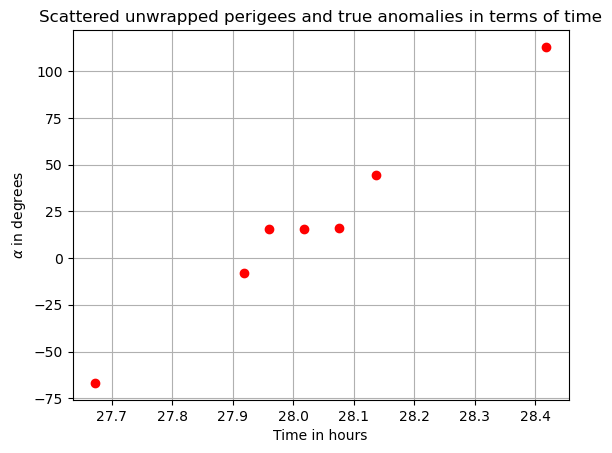

In [111]:
time = np.array(time)
pa = np.array(pa)
positions = np.array(positions)
ohm = np.array(ohm)
inc = np.array(inc)

sigma_indices = [0, 1, 2, 3, 4, 5, 6]
sorted_indices = np.argsort(time)
time_sorted = time[sorted_indices]
pa_sorted = pa[sorted_indices]
ohm_sorted = ohm[sorted_indices]
inc_sorted = inc[sorted_indices]
reverse_lookup = {orig_idx: new_idx for new_idx, orig_idx in enumerate(sorted_indices)}
sigma_sorted_indices = [reverse_lookup[i] for i in sigma_indices]
unwrapped_pa = np.array(unwrap_angles(pa_sorted))

plt.figure()
plt.scatter(time[7:], pa[7:], color = "orange", alpha = 0.3, marker = "+")
plt.scatter(time[:7], pa[:7], color = "red")
plt.title("$\\alpha$ angle in terms of time of propagation")
plt.xlabel("Time in hours")
plt.ylabel("$\\alpha$ in degrees")
plt.grid(True)
plt.show()

plt.figure()
plt.scatter(time_sorted, unwrapped_pa, color = "orange", alpha = 0.3, marker = "+")
plt.scatter(time_sorted[sigma_sorted_indices], unwrapped_pa[sigma_sorted_indices], color = "red")
plt.xlabel("Time in hours")
plt.ylabel("$\\alpha$ in degrees")
plt.title("Scattered unwrapped perigees and true anomalies in terms of time")
plt.grid(True)
plt.show()


This part of the code, I'll try to change it so the $\alpha$ angle doesn't vary from -$\pi$ to $\pi$, but instead is also unwrapped, to see if there is a better fit that can be obtained like that.

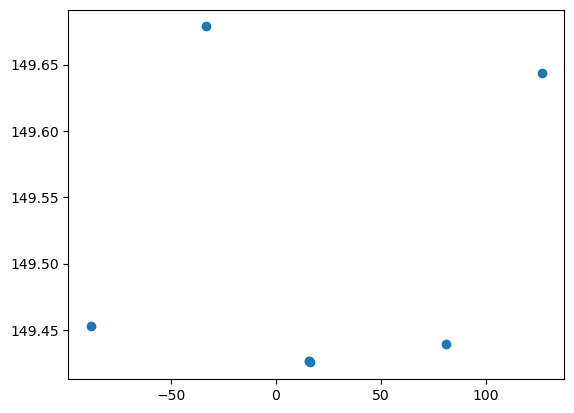

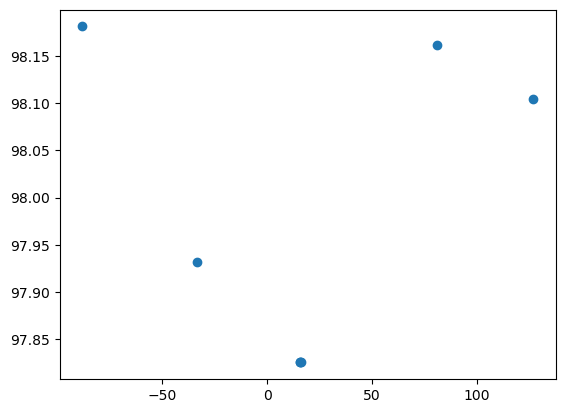

In [90]:
plt.figure()
plt.scatter(unwrapped_pa, ohm_sorted)
plt.show()

plt.figure()
plt.scatter(unwrapped_pa, inc_sorted)
plt.show()


Fitted inclination parameters (i0, i1, i2): [ 9.79248919e+01 -6.65551636e-02  1.71805749e-01]
Fitted RAAN parameters (Ω₀, Ω̇, Ω₁, Ω₂): [149.54590583  -1.35343819   2.29603827  -0.60873179]


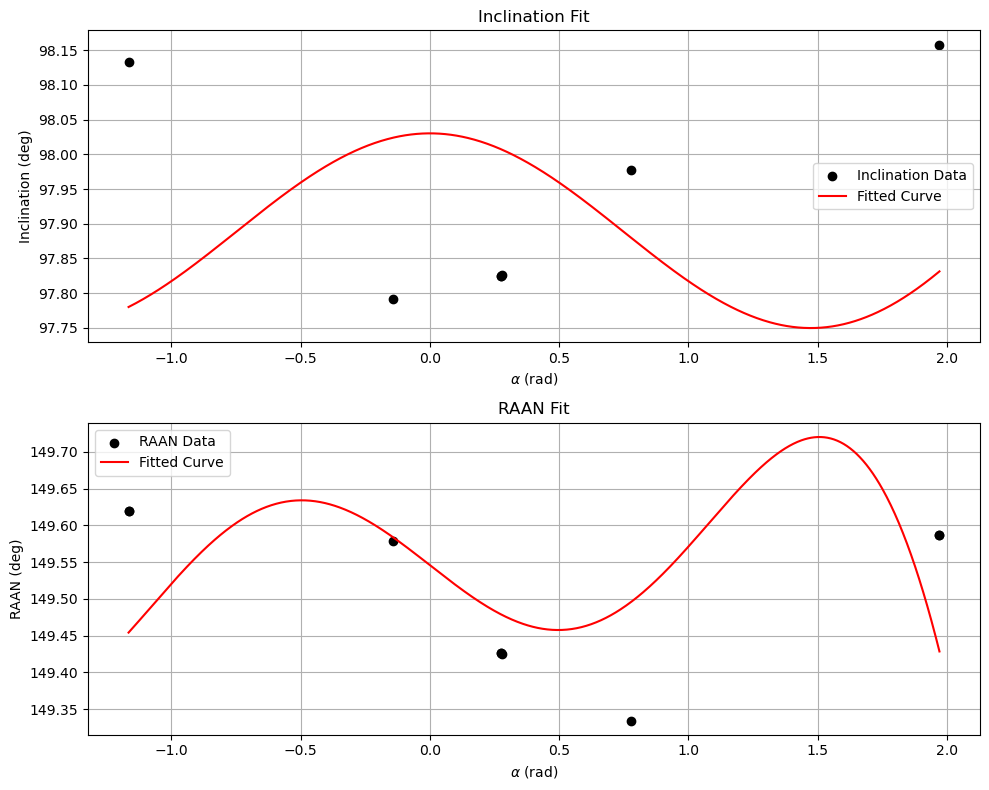

In [112]:
alpha_rad = np.radians(unwrapped_pa)

def raan_model_unwrapped(alpha, omega0, omega_alpha, omega1, omega2):
    return omega0 + omega_alpha*alpha + omega1 * np.sin(alpha) + omega2 * np.sin(2 * alpha)

indices = sigma_sorted_indices.copy()
indices.append(-1)
indices.insert(0,0)

popt_i_unwrapped, _ = curve_fit(inclination_model, alpha_rad, inc)
print("Fitted inclination parameters (i0, i1, i2):", popt_i_unwrapped)


popt_omega_unwrapped, _ = curve_fit(raan_model_unwrapped, alpha_rad, ohm)
print("Fitted RAAN parameters (Ω₀, Ω̇, Ω₁, Ω₂):", popt_omega_unwrapped)

alpha_fit = np.linspace(min(alpha_rad), max(alpha_rad), 1000)
t_fit = np.linspace(min(time), max(time), 1000)

i_fit = inclination_model(alpha_fit, *popt_i_unwrapped)
omega_fit = raan_model_unwrapped(alpha_fit, *popt_omega_unwrapped)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].scatter(alpha_rad, inc_sorted, s = 10, alpha = 0.3)
axs[0].scatter(alpha_rad[sigma_sorted_indices], inc_sorted[sigma_sorted_indices], label='Inclination Data', color = 'black')
axs[0].plot(alpha_fit, i_fit, 'r', label='Fitted Curve')
axs[0].set_title("Inclination Fit")
axs[0].set_xlabel("$\\alpha$ (rad)")
axs[0].set_ylabel("Inclination (deg)")
axs[0].legend()
axs[0].grid(True)

axs[1].scatter(alpha_rad, ohm_sorted, s = 10, alpha = 0.3)
axs[1].scatter(alpha_rad[indices], ohm_sorted[indices], label='RAAN Data', color = 'black')
axs[1].plot(alpha_fit, omega_fit, 'r', label='Fitted Curve')
axs[1].set_title("RAAN Fit")
axs[1].set_xlabel("$\\alpha$ (rad)")
axs[1].set_ylabel("RAAN (deg)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

This code will pick the transformed sigma points due to the propagation and create a Gaussian ellipse from it. It will then plot this ellipse onto the unwrapped alpha in terms of time plot, whilst creating a list of the points that the ellipse needs to be plotted.

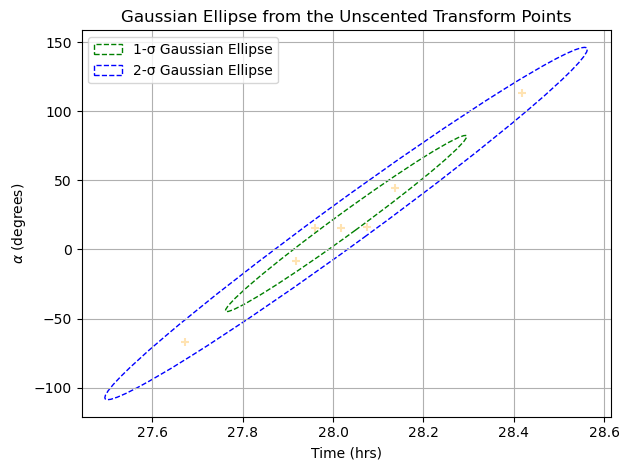

In [113]:
final_sig_points = [(t, x) for t, x in zip(time_sorted[sigma_sorted_indices], unwrapped_pa[sigma_sorted_indices])]
final_sig_points = np.array(final_sig_points)
final_sig_points = final_sig_points[np.argsort(final_sig_points[:, 0])]
final_sig_points = np.delete(final_sig_points, [1, 5], axis=0)

final_mean = np.mean(final_sig_points, axis=0)
final_covariance = np.cov(final_sig_points, rowvar=False)

plt.figure()
ax = plt.gca()
plt.grid(True)
plt.scatter(time_sorted, unwrapped_pa, marker = "+", color = "orange", alpha = 0.3)
ellipse1_points = plot_ellipse(final_mean, final_covariance, ax, n_std=1, facecolor='none', edgecolor='green', linestyle = '--', label = '1-σ Gaussian Ellipse') 
ellipse2_points = plot_ellipse(final_mean, final_covariance, ax, n_std=2, facecolor='none', edgecolor='blue', linestyle = '--', label = '2-σ Gaussian Ellipse')  
plt.title("Gaussian Ellipse from the Unscented Transform Points")
plt.xlabel("Time (hrs)")
plt.ylabel("$\\alpha$ (degrees)")
plt.legend()
plt.tight_layout()
plt.show()

ellipse1_points[:, 1] = np.radians(ellipse1_points[:, 1])
ellipse2_points[:, 1] = np.radians(ellipse2_points[:, 1])

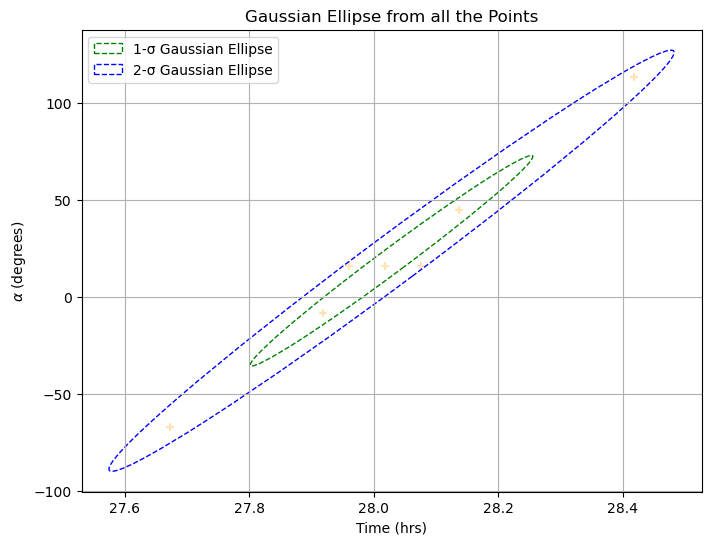

In [114]:
all_points = [(t, x) for t, x in zip(time_sorted, unwrapped_pa)]
all_points = np.array(all_points)

points_mean = np.mean(all_points, axis = 0)
points_cov = np.cov(all_points.T)

eigvals, eigvecs = np.linalg.eigh(points_cov)
order = eigvals.argsort()[::-1]
eigvals = eigvals[order]
eigvecs = eigvecs[:, order]

angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
width, height = 2 * np.sqrt(eigvals)

n_std = 1

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(all_points[:, 0], all_points[:, 1], alpha=0.3, color = 'orange', marker = '+')
plot_ellipse(points_mean, points_cov, ax, n_std=1, facecolor='none', edgecolor='green', linestyle = '--', label = '1-σ Gaussian Ellipse') 
plot_ellipse(points_mean, points_cov, ax, n_std=2, facecolor='none', edgecolor='blue', linestyle = '--', label = '2-σ Gaussian Ellipse')   
ax.set_title('Gaussian Ellipse from all the Points')
plt.xlabel("Time (hrs)")
plt.ylabel("$\\alpha$ (degrees)")
plt.grid(True)
plt.legend()
plt.show()

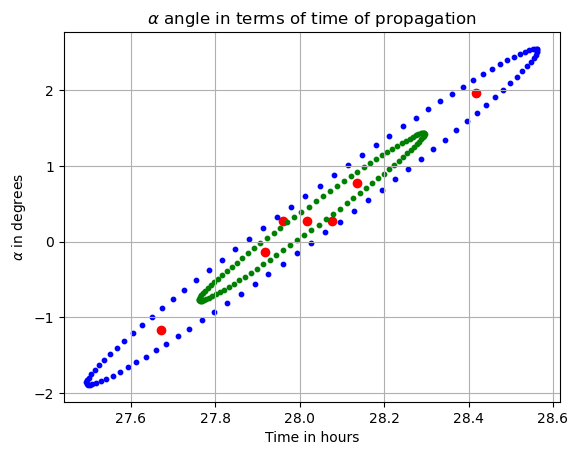

In [115]:
ellipse1_wrapped = ellipse1_points.copy()
ellipse2_wrapped = ellipse2_points.copy()
for k in range(len(ellipse1_wrapped)):
    if ellipse1_wrapped[k][1]>np.pi:
        ellipse1_wrapped[k][1] = ellipse1_wrapped[k][1]-2*np.pi
    if ellipse2_wrapped[k][1]>np.pi:
        ellipse2_wrapped[k][1] = ellipse2_wrapped[k][1]-2*np.pi

pa_rad = np.radians(pa)

plt.figure()
plt.scatter(time[7:], pa_rad[7:], color = "orange", alpha = 0.3, marker = "+")
plt.scatter(time[:7], pa_rad[:7], color = "red")
plt.scatter(ellipse1_wrapped[:,0], ellipse1_wrapped[:,1], s=10, color= 'green')
plt.scatter(ellipse2_wrapped[:,0], ellipse2_wrapped[:,1], s=10, color= 'blue')
plt.title("$\\alpha$ angle in terms of time of propagation")
plt.xlabel("Time in hours")
plt.ylabel("$\\alpha$ in degrees")
plt.grid(True)
plt.show()

This part of the code will simply plot the histograms of the inclination and the right ascencion of the ascending node.

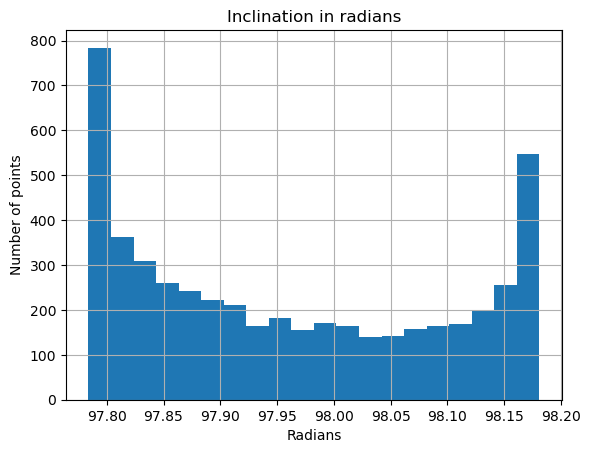

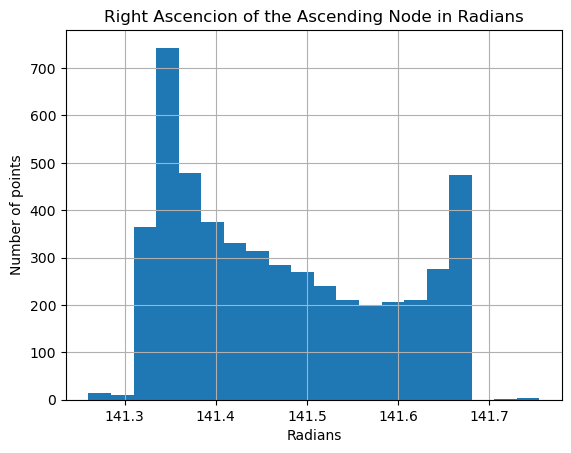

In [91]:
plt.figure()
plt.hist(inc, bins = 20)
plt.title("Inclination in radians")
plt.xlabel("Radians")
plt.grid(True)
plt.ylabel("Number of points")
plt.show()

plt.figure()
plt.hist(ohm, bins = 20)
plt.xlabel("Radians")
plt.ylabel("Number of points")
plt.grid(True)
plt.title("Right Ascencion of the Ascending Node in Radians")
plt.show()

This part of the code showcases in 3D the points at which the satellite reaches 80km of altitude, without considering Earth's rotation.

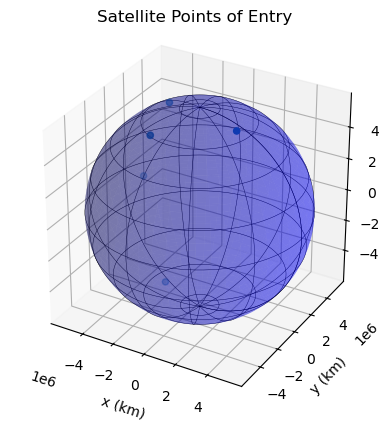

In [116]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:,0], positions[:,1], positions[:,2], label = "Orbit Trajectory")
u, v = np.linspace(0, 2*np.pi, 100), np.linspace(0, np.pi, 100)
U, V = np.meshgrid(u, v)
x_earth = Constants.WGS84_EARTH_EQUATORIAL_RADIUS*np.cos(U)*np.sin(V)
y_earth = Constants.WGS84_EARTH_EQUATORIAL_RADIUS*np.sin(U)*np.sin(V)
z_earth = Constants.WGS84_EARTH_EQUATORIAL_RADIUS*np.cos(V)
ax.plot_surface(x_earth, y_earth, z_earth, color = "blue", alpha = 0.3)
for lati in np.linspace(-80, 80, 9):
    lat_rad = np.radians(lati)
    theta = np.linspace(0, 2 * np.pi, 100)
    x = Constants.WGS84_EARTH_EQUATORIAL_RADIUS * np.cos(theta) * np.cos(lat_rad)
    y = Constants.WGS84_EARTH_EQUATORIAL_RADIUS * np.sin(theta) * np.cos(lat_rad)
    z = Constants.WGS84_EARTH_EQUATORIAL_RADIUS * np.sin(lat_rad)
    ax.plot(x, y, z, color='k', linewidth=0.3)

for long in np.linspace(0, 360, 12):
    lon_rad = np.radians(long)
    phi = np.linspace(-np.pi / 2, np.pi / 2, 100)
    x = Constants.WGS84_EARTH_EQUATORIAL_RADIUS * np.cos(phi) * np.cos(lon_rad)
    y = Constants.WGS84_EARTH_EQUATORIAL_RADIUS * np.cos(phi) * np.sin(lon_rad)
    z = Constants.WGS84_EARTH_EQUATORIAL_RADIUS * np.sin(phi)
    ax.plot(x, y, z, color='k', linewidth=0.3)
ax.set_title("Satellite Points of Entry")
ax.set_box_aspect([1,1,1])
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('z (km)')
ax.set_xlim(np.min(positions[:,:3]),np.max(positions[:,:3]))
ax.set_ylim(np.min(positions[:,:3]),np.max(positions[:,:3]))
ax.set_zlim(np.min(positions[:,:3]),np.max(positions[:,:3]))
plt.show()

This converts the ellipse points into latitudes and longitudes, by considering that only the time and perigee angles vary, which means that we take the mean satellite point and simply vary its initial parameters with the new perigee and time. This is obviously not correct, and is not a good way to approximate it, which is why we will be fitting the inclination and the right ascencion of the ascending node to determine better orbital parameters for the ellipse to determine its longitude and latitude.

In [117]:
ell1_orb_coords = []
ell2_orb_coords = []
ell1_x = []
ell1_y = []
ell1_z = []
ell1_lat = []
ell1_lon = []
ell2_x = []
ell2_y = []
ell2_z = []
ell2_lat = []
ell2_lon = []

for k in range(len(ellipse1_wrapped)):
    time_ell1, alpha_ell1 = ellipse1_wrapped[k]
    inc_ell1 = inclination_model(ellipse1_wrapped[k][1], popt_i[0], popt_i[1], popt_i[2])
    raan_ell1 = raan_model([ellipse1_wrapped[k,1], ellipse1_wrapped[k,0]], popt_omega[0], popt_omega[1], popt_omega[2], popt_omega[3])
    time_ell2, alpha_ell2 = ellipse2_wrapped[k]
    inc_ell2 = inclination_model(ellipse2_wrapped[k][1], popt_i[0], popt_i[1], popt_i[2])
    raan_ell2 = raan_model([ellipse2_wrapped[k,1], ellipse2_wrapped[k,0]], popt_omega[0], popt_omega[1], popt_omega[2], popt_omega[3])
    ell1_orbit = KeplerianOrbit(float(Constants.WGS84_EARTH_EQUATORIAL_RADIUS+80000.0), float(0.0), float(np.radians(inc_ell1)),
         float(alpha_ell1), float(np.radians(raan_ell1)), float(0.0),
         PositionAngleType.TRUE, final_state.getFrame(), initialDate.shiftedBy(float(time_ell1*3600.0)), Constants.WGS84_EARTH_MU)
    ell1_x.append(ell1_orbit.getPosition().getX())
    ell1_y.append(ell1_orbit.getPosition().getY())
    ell1_z.append(ell1_orbit.getPosition().getZ())
    p = ell1_orbit.getPosition()
    subpoint = earth.transform(p, inertialFrame, initialDate.shiftedBy(float(time_ell1*3600.0)))
    ell1_lat.append(np.degrees(subpoint.getLatitude()))
    ell1_lon.append(np.degrees(subpoint.getLongitude()))
    ell2_orbit = KeplerianOrbit(float(Constants.WGS84_EARTH_EQUATORIAL_RADIUS+80000.0), float(0.0), float(np.radians(inc_ell2)),
         float(alpha_ell2), float(np.radians(raan_ell2)), float(0.0),
         PositionAngleType.TRUE, final_state.getFrame(), initialDate.shiftedBy(float(time_ell2*3600.0)), Constants.WGS84_EARTH_MU)
    ell2_x.append(ell2_orbit.getPosition().getX())
    ell2_y.append(ell2_orbit.getPosition().getY())
    ell2_z.append(ell2_orbit.getPosition().getZ())
    p = ell2_orbit.getPosition()
    subpoint = earth.transform(p, inertialFrame, initialDate.shiftedBy(float(time_ell2*3600.0)))
    ell2_lat.append(np.degrees(subpoint.getLatitude()))
    ell2_lon.append(np.degrees(subpoint.getLongitude()))


In [118]:

alt = np.array([80]*len(ell1_lon))
elx = (alt+6378) * np.cos(np.radians(ell2_lat)) * np.cos(np.radians(ell2_lon))
ely = (alt+6378) * np.cos(np.radians(ell2_lat)) * np.sin(np.radians(ell2_lon))
elz = (alt+6378) * np.sin(np.radians(ell2_lat))

print(ell2_lon)
print(ell2_lat)
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(x=elx,y=ely,z=elz,
                                   mode='markers',marker=dict(size=5, color='blue', opacity=0.7))])


latitudes = np.arange(-90, 91, 10)
for lati in latitudes:
    lat_x = np.cos(np.radians(lati)) * np.cos(np.radians(np.linspace(0, 360, 100))) * 6371
    lat_y = np.cos(np.radians(lati)) * np.sin(np.radians(np.linspace(0, 360, 100))) * 6371
    lat_z = np.full_like(lat_x, 6371 * np.sin(np.radians(lati)))
    
    fig.add_trace(go.Scatter3d(x=lat_x, y=lat_y, z=lat_z,mode='lines',line=dict(color='green', width=2)))

longitudes = np.arange(-180, 181, 30)
for long in longitudes:
    lon_x = np.cos(np.radians(np.linspace(-90, 90, 100))) * np.cos(np.radians(long)) * 6371
    lon_y = np.cos(np.radians(np.linspace(-90, 90, 100))) * np.sin(np.radians(long)) * 6371
    lon_z = np.sin(np.radians(np.linspace(-90, 90, 100))) * 6371
    
    fig.add_trace(go.Scatter3d(x=lon_x, y=lon_y, z=lon_z,mode='lines',line=dict(color='red', width=2)))

fig.update_layout(scene=dict(xaxis_title="X",yaxis_title="Y",zaxis_title="Z"))
fig.write_html("satellite_plot.html")
fig.show()


[165.5236852215188, 165.50462787510375, 165.62305449810185, 165.87959799099892, 166.2782949944317, 166.82729422026324, 167.5402817761534, 168.43898490293006, 169.55748830272702, 170.94986885027785, 172.70438760691408, 174.97171349804057, 178.02605993622524, -177.58746705222427, -170.64854298818827, -158.0025850636301, -131.24715019241958, -86.25794369636104, -54.28464139274022, -39.18413042295888, -31.102469599836585, -26.00434012008417, -22.374228083059734, -19.554576020511966, -17.219556974669782, -15.189414345583774, -13.355445749834509, -11.645924516984476, -10.008926088740395, -8.402688605016785, -6.789388863766986, -5.130229386088278, -3.38045732217197, -1.4829896162038076, 0.6412208777482088, 3.109412816237192, 6.106600866172036, 9.943329979559602, 15.175606128636439, 22.863316611659137, 35.08127837045788, 55.232232902890516, 83.88999741669079, 110.73570119858033, 128.15491157795995, 138.4137509791751, 144.63326031421596, 148.54317293561022, 151.01351951229765, 152.4904456303747

This creates the ground track for visualisation of the satellite points and the ellipse points. There is a clear issue stemming from the ellipse points as they do not encase the points well enough. This must be due to the code directly inputting the $\alpha$ angle in as the perigee angle, when it is a combination of the perigee and the true anomaly. Will get back to this soon.

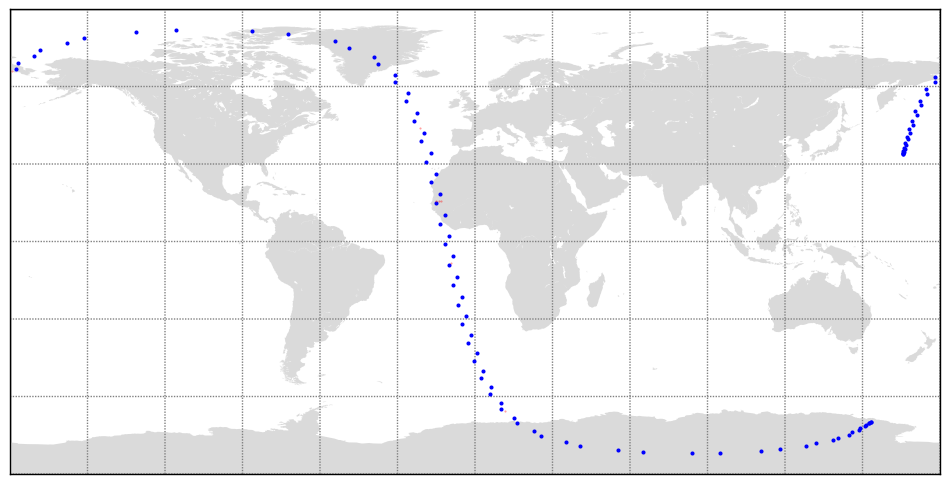

In [119]:
fig = plt.figure(figsize=(12, 10))
m = Basemap(projection='cyl',
            resolution='l',
            area_thresh=None)

m.drawmapboundary()
m.fillcontinents(color='#dadada', lake_color='white')
m.drawmeridians(np.arange(-180, 180, 30), color='gray')
m.drawparallels(np.arange(-90, 90, 30), color='gray')
m.scatter(ell2_lon, ell2_lat, s = 15, alpha = 1, color = 'blue', zorder=3, marker='.')
m.scatter(lon, lat, s=1, alpha=0.4, color='red', zorder=3, marker='.')

#change RAAN to put all points in ocean

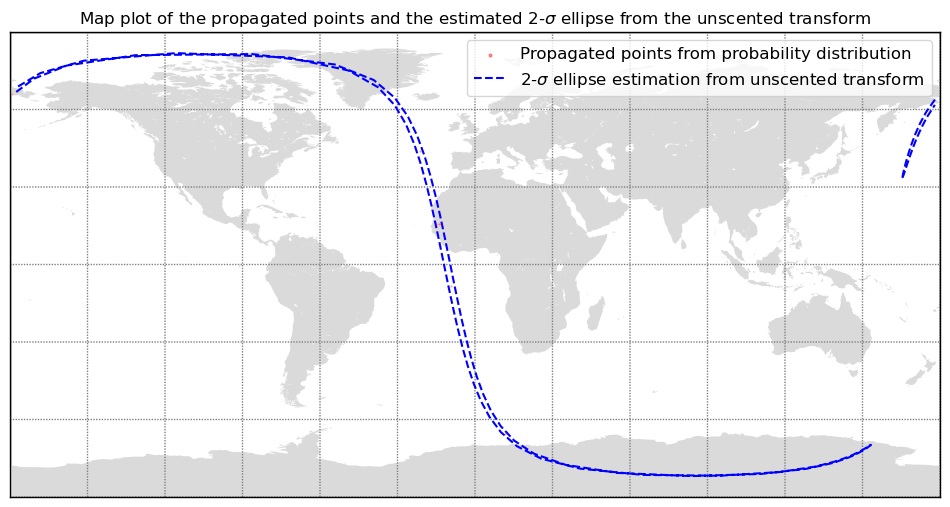

In [120]:
def break_ground_track(lons, lats, threshold=180):
    segments = []
    segment_lon = [lons[0]]
    segment_lat = [lats[0]]

    for i in range(1, len(lons)):
        if abs(lons[i] - lons[i-1]) > threshold / 2:
            # Discontinuity found
            segments.append((segment_lon, segment_lat))
            segment_lon = [lons[i]]
            segment_lat = [lats[i]]
        else:
            segment_lon.append(lons[i])
            segment_lat.append(lats[i])
    segments.append((segment_lon, segment_lat))
    return segments

# Break the blue track into segments
blue_segments = break_ground_track(ell2_lon, ell2_lat)
green_segments = break_ground_track(ell1_lon, ell1_lat)



g = plt.figure(figsize=(12, 10))
m = Basemap(projection='cyl',
            resolution='l',
            area_thresh=None)

m.drawmapboundary()
m.fillcontinents(color='#dadada', lake_color='white')
m.drawmeridians(np.arange(-180, 180, 30), color='gray')
m.drawparallels(np.arange(-90, 90, 30), color='gray')
m.scatter(lon, lat, s=1, alpha=0.4, color='red', zorder=3, marker='.', label = "Propagated points from probability distribution")
i = 1
for lon_seg, lat_seg in blue_segments:
    if i==1:
        m.plot(lon_seg, lat_seg, latlon=True, color='blue', linestyle = "--", label = "2-$\\sigma$ ellipse estimation from unscented transform")
        i+=1
    else:
        m.plot(lon_seg, lat_seg, latlon=True, color='blue', linestyle = "--")

plt.title("Map plot of the propagated points and the estimated 2-$\\sigma$ ellipse from the unscented transform")
plt.legend(markerscale=4, loc='upper right', fontsize=12)


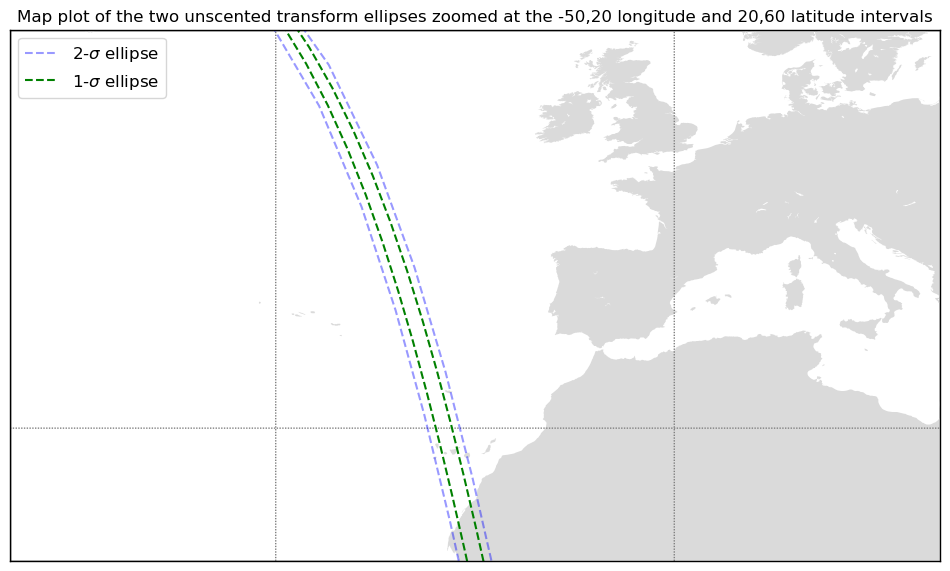

In [121]:
ll_lon, ll_lat = -50, 20   # lower-left corner (longitude, latitude)
ur_lon, ur_lat = 20, 60   # upper-right corner

g = plt.figure(figsize=(12, 10))
m = Basemap(projection='cyl',  # Cylindrical projection works well for small regions
            llcrnrlon=ll_lon, llcrnrlat=ll_lat,
            urcrnrlon=ur_lon, urcrnrlat=ur_lat,
            resolution='i')  # intermediate resolution



m.drawmapboundary()
m.fillcontinents(color='#dadada', lake_color='white')
m.drawmeridians(np.arange(-180, 180, 30), color='gray')
m.drawparallels(np.arange(-90, 90, 30), color='gray')
i = 1
for lon_seg, lat_seg in blue_segments:
    if i == 1:
        m.plot(lon_seg, lat_seg, latlon=True, color='blue', linestyle = "--", alpha = 0.4, label = '2-$\\sigma$ ellipse')
        i+=1
    else:
        m.plot(lon_seg, lat_seg, latlon=True, color='blue', linestyle = "--", alpha = 0.4)
i = 1
for lon_seg, lat_seg in green_segments:
    if i == 1:
        m.plot(lon_seg, lat_seg, linestyle= "--", color = "green", label = '1-$\\sigma$ ellipse')
        i += 1
    else:
        m.plot(lon_seg, lat_seg, linestyle= "--", color = "green")
plt.title("Map plot of the two unscented transform ellipses zoomed at the -50,20 longitude and 20,60 latitude intervals")
plt.legend(fontsize = 12)